## This version Simulates IA on a Logrithmic Scale
#### Features
- General density and angular distributions are enabled
- Density Profile Tracking enabled
- Different built-in sampling methods enabled
- 7/27 Now each function value such as gamma, density, is stored in the format [[r...],[f(r)...]]

#### Deprecation
- 7/27 density 2D deprecated, if needed, refer to version 1
- R_cut deprecated: everything radial should be normalized before input
- 3D-catalogue-building(All_Sats) deprecated
- All_Sats_2D deprecated, merged into the vector Proj_Data to conserve disk space

#### run_folder name standard (the master folder of each condition's run is called outputpath):
- 'mod n n baR baR smr smr' etc... the second instance is the actual number. seperated by nothing but space

### Modules generated by respectively named jupyter notebooks

### Main Function:

In [15]:
%%writefile ia_main.py
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
import sys
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#local modules, no name conflicts
from ia_geometry_func import *
from execution_func import *

###############################################################################################################
########                     This block contains the core functions for this simulation                ########
########                               Check for Rank-Dependence before running                        ########
###############################################################################################################

def get_RA_data(save_2D,iteration_tracker,outputpath,mode,n,baR_0,a1,a2,rhostd): 
    import sys
    #n=64 ~ 1min30sec
    
    #x,y,z are of size 2n+1, {+1,-1, and 0 always included to prevent singularities in functions}
    if mode == 'linear':
        xs = get_axis_lin(n)
        ys = get_axis_lin(n)
        zs = get_axis_lin(n)
    if mode == 'linear_cut': #To be implemented
        xs = None
        ys = None
        zs = None
        sys.exit('code not ready')
    if mode == 'log':
        xs = get_axis_log(n)
        ys = get_axis_log(n)
        zs = get_axis_log(n)
    
    #get a list of mid points and cell widths for later computing values in each simulated cell
    midx = get_mid_points(xs)
    midy = get_mid_points(ys)
    midz = get_mid_points(zs)
    diffx = get_diff_list(xs)
    diffy = get_diff_list(ys)
    diffz = get_diff_list(zs)
    
    #this prevents the density function later used become to small for numeric purposes
    #this will get divided out later. doesnt really matter
    #total_number_of_sats = (2*n)**3
    
    #[[x_cell_midpt, y_cell_midpt, r , sum_eps+(midpt)_at_xy, sum_numberfraction(midpt)_at_xy]]
    #This will be saved in file. # x, y are only used to plot the 2D density profile. Otherwise, r is enough
    Proj_Data=np.empty((0,3))
    #totalmass_t1 = 0.0
    
    for x_index in range(2*n):
        #looping in range2*n ensures never out of bound
        #midpoint_cell_coordinate will be referred to as = x,y,z.
        x = midx[x_index]
        dx = diffx[x_index]
        
        for y_index in range(2*n):
            y = midy[y_index]
            dy = diffy[y_index]
            
            [[global_polar_r,global_phi]] = Cart_to_Polar(np.array([[x,y]]))
            weighted_orients_same_r = np.zeros(2) #stores np.array: [sum_of_weighted_epsilon+_at_r, sum_of_rho_at_r]

            for z_index in range(2*n):
                z = midz[z_index]
                dV=dx*dy*diffz[z_index]
                
                #print(dV)
                
                #global here refers to global coordinates
                #local meanning local to the cell, evaluated at cell midpt
                #[[global_r,global_theta,global_phi]] = Cart_to_Sph(np.array([[x,y,z]]))   #get sat's position in global sph coord
                global_r = np.sqrt(global_polar_r**2+z**2)
                global_theta = RZ_to_Theta(np.array([[global_polar_r,z]]))
                #each function will decide if (xyz) or (r,theta, phi) is faster
                #other parameters are defined globally before this function is run
                local_num_fraction = density_func(x,y,z,global_r,global_theta,global_phi,rhostd)*dV#*total_number_of_sats    #density * volume
                local_baR          = baR_func(x,y,z,global_r,global_theta,global_phi)
                local_theta        = theta_func(x,y,z,global_r,global_theta,global_phi,a1,a2)
                local_phi          = phi_func(x,y,z,global_r,global_theta,global_phi,a1,a2)
                
                #get sat's orientation (see nnote below!!!) in local sph and cartesian coord. #not very useful, deactivated.
                #But IMPORTANT to note that
                #This vector IS NOT WHAT SATELLITEs PHYSICALLY LOOKLIKE. R direction encodes b/a Ratio. 
                #But this vector physically parallels the satellite's shape
                #local_baR_vector = np.array([[local_baR,local_theta,local_phi]]) 
                #[[local_x,local_y,local_z]] = Sph_to_Cart(local_baR_vector)

                proj_mag = Ellip_proj_mag(local_baR,local_theta)    #calculate the projected b/a Ratio first
                #print('p to eps',Polar_to_eps(global_phi,proj_mag,local_phi))
                #print(local_num_fraction)
                weighted_orients_same_r[0]+=Polar_to_eps(global_phi,proj_mag,local_phi)*local_num_fraction #sum over z
                weighted_orients_same_r[1]+=local_num_fraction
                #print(weighted_orients_same_r)
                #totalmass_t1 += local_num_fraction
            
            Proj_Data = np.vstack((Proj_Data,np.array([
                                   #x,
                                   #y,
                                   global_polar_r,
                                   weighted_orients_same_r[0],        #Epsilon summed and weighted over z
                                   weighted_orients_same_r[1]])))     #local density summed over z
    
    #Now reduce the 2D data to 1D: perform radial averaging and get the gamma+ function
    #get the radial axis from 0 to 1, this has size n+1. Will later take the number of intervals, 
    #and will thus reduce the size of radial axis to n
    #print('direct sum of mass',totalmass_t1)
    
    if mode == 'linear':
        rs = get_axis_lin(n)[n:2*n+1]
    if mode == 'linear_cut': #To be implemented
        rs = None
        sys.exit('code not ready')
    if mode == 'log':
        rs = get_axis_log(n)[n:2*n+1]
    
    gamma_plus = np.zeros(n) #size=n
    densities = np.zeros(n)
    
    totalmasscount = 0.0
    for i in range(n): # n = len(rs)-1. i.e. there is nothing beyond R_cut
        #each i is a radial interval
        #print(rs[i])
        count=0.0
        #print(Proj_Data)
        for elmt in Proj_Data:
            #print(elmt)
            # if in the first, second, third, radial interval(s)... and so on.
            xyplane_dist = elmt[0]
            if (xyplane_dist >= rs[i] and xyplane_dist < rs[i+1]):
                gamma_plus[i] += elmt[1]
                count += elmt[2] #adds up the total number density, in case it is 0, and cannot be used to average Gamma+
        #print(gamma_plus[i],count)
        if (count == 0):
            gamma_plus[i]=0
        else: 
            gamma_plus[i]=gamma_plus[i]/count
        
        totalmasscount += count
        densities[i] = count/(rs[i+1]-rs[i]) #number/length! NOT AREA!
        
    #print('total mass count = ', totalmasscount)
    rs = get_mid_points(rs)
    densities=densities/totalmasscount
    
    #stores[[Radial coord],function values]
    #print(gamma_plus)
    #print(rs)
    gamma_plus = np.vstack((rs,gamma_plus))
    #print(gamma_plus)
    densities = np.vstack((rs,densities))
                
    if save_2D == True:
        write_file_at_path(outputpath, 'gamma_plus', gamma_plus,str(iteration_tracker)+mode+'mod')
        write_file_at_path(outputpath, 'densities', densities,str(iteration_tracker)+mode+'mod')

###############################################################################################################
########                     This block contains Setups for this simulation                            ########
########                     Scroll to the end of file to code executions                              ########
########                     Check for Rank-Dependence before running                                  ########
###############################################################################################################

def baR_func(x,y,z,global_r,global_theta,global_phi): 
    return baR_0#+np.random.normal(0,0) #b/a ratio has an 

def theta_func(x,y,z,global_r,global_theta,global_phi,a1,a2): 
    #### GAUSSIAN NOISE
    #return global_theta+np.random.normal(0,a2) #(center, std)
    return global_theta+np.random.normal(0,a1*global_r+a2) #(center, std)

def phi_func(x,y,z,global_r,global_theta,global_phi,a1,a2): 
    #### GAUSSIAN NOISE
    #return global_theta+np.random.normal(0,a2) #(center, std)
    return global_phi+np.random.normal(0,a1*global_r+a2)

def density_func(x,y,z,global_r,global_theta,global_phi,std): #NEED TO BE NORMALIZED
    # this gives the Fraction NUMBER of gals expected in a box of size dV, approximated at (x,y,z)
    # should normalize to 1, but given the finiteness of n,  this only holds as n gets large
    if (global_r > 1): return 0
    else: 
        #return 1/(4*np.pi/3)
        #return np.abs(np.random.normal(1,std))/((global_r*concentration)*(1+global_r*concentration)**2)
        return np.abs(np.random.normal(1,std))/((global_r*concentration)*(1+global_r*concentration)**2)
    
n=32
baR_0 = 0.3
concentration = 20 #R_virial = Rs*c. since R_virial is usually chosen as the cut of limit for density profiles, we set it to 1.
a1s = np.linspace(0,np.pi/2,10)
a2s = np.linspace(0,np.pi/2,10)
#smr_slope_run = 0#np.pi/8 #radians/normalized_distance
#smr_intercept_run = np.pi/8 #radians
density_std = 0 #fractional difference as std
offset = 0
size_per_rank = 10
for smr_slope_run in a1s:
    for smr_intercept_run in a2s:
        run_folder = 'n %i c %i rhostd %1.2f baR_0 %1.2f slp %1.2f itcp %1.2f'%(n,concentration,density_std,baR_0,rad_to_deg(smr_slope_run),rad_to_deg(smr_intercept_run))
        print('starting rank',rank,' on a new condition')

        def run_rank_sing_cond(node_index,batch_num,offset): 
            if rank == node_index:
                if batch_num == 0:
                    for i in range(size_per_rank):
                        get_RA_data(True,rank+i*7,outputpath,'linear',n,baR_0,smr_slope_run,smr_intercept_run,density_std)
                        print('batch1 rank'+str(rank)+': task finished '+str(rank+i*7)+'out of total'+str(14*size_per_rank-1))
                if batch_num == 1:
                    for i in range(size_per_rank):
                        get_RA_data(True,(rank+(i+size_per_rank-1)*7),outputpath,'log',n,baR_0,smr_slope_run,smr_intercept_run,density_std)
                        print('batch2 rank'+str(rank)+': task finished '+str((rank+(i+size_per_rank-1)*7))+'out of total'+str(14*size_per_rank-1))

        outputpath = '/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/Linear Smearing'
        outputpath = os.path.join(outputpath,run_folder)
        #get_RA_data(True,1,outputpath,'linear',n,baR_0,smr_run,smr_run)

        #how ever many slot you want to run: usually 7 per batch, 2 batches,  for 14 threads in total
        run_rank_sing_cond(0,0,offset)
        run_rank_sing_cond(1,0,offset)
        run_rank_sing_cond(2,0,offset)
        run_rank_sing_cond(3,0,offset)
        run_rank_sing_cond(4,0,offset)
        run_rank_sing_cond(5,0,offset)
        run_rank_sing_cond(6,0,offset)
        time.sleep(2) #this gives time for the previous threads to create directories, etcs.
        #Note this time difference is repeated every loop
        run_rank_sing_cond(7,1,offset)
        run_rank_sing_cond(8,1,offset)
        run_rank_sing_cond(9,1,offset)
        run_rank_sing_cond(10,1,offset)
        run_rank_sing_cond(11,1,offset)
        run_rank_sing_cond(12,1,offset)
        run_rank_sing_cond(13,1,offset)
        run_rank_sing_cond(14,1,offset)

Overwriting ia_main.py


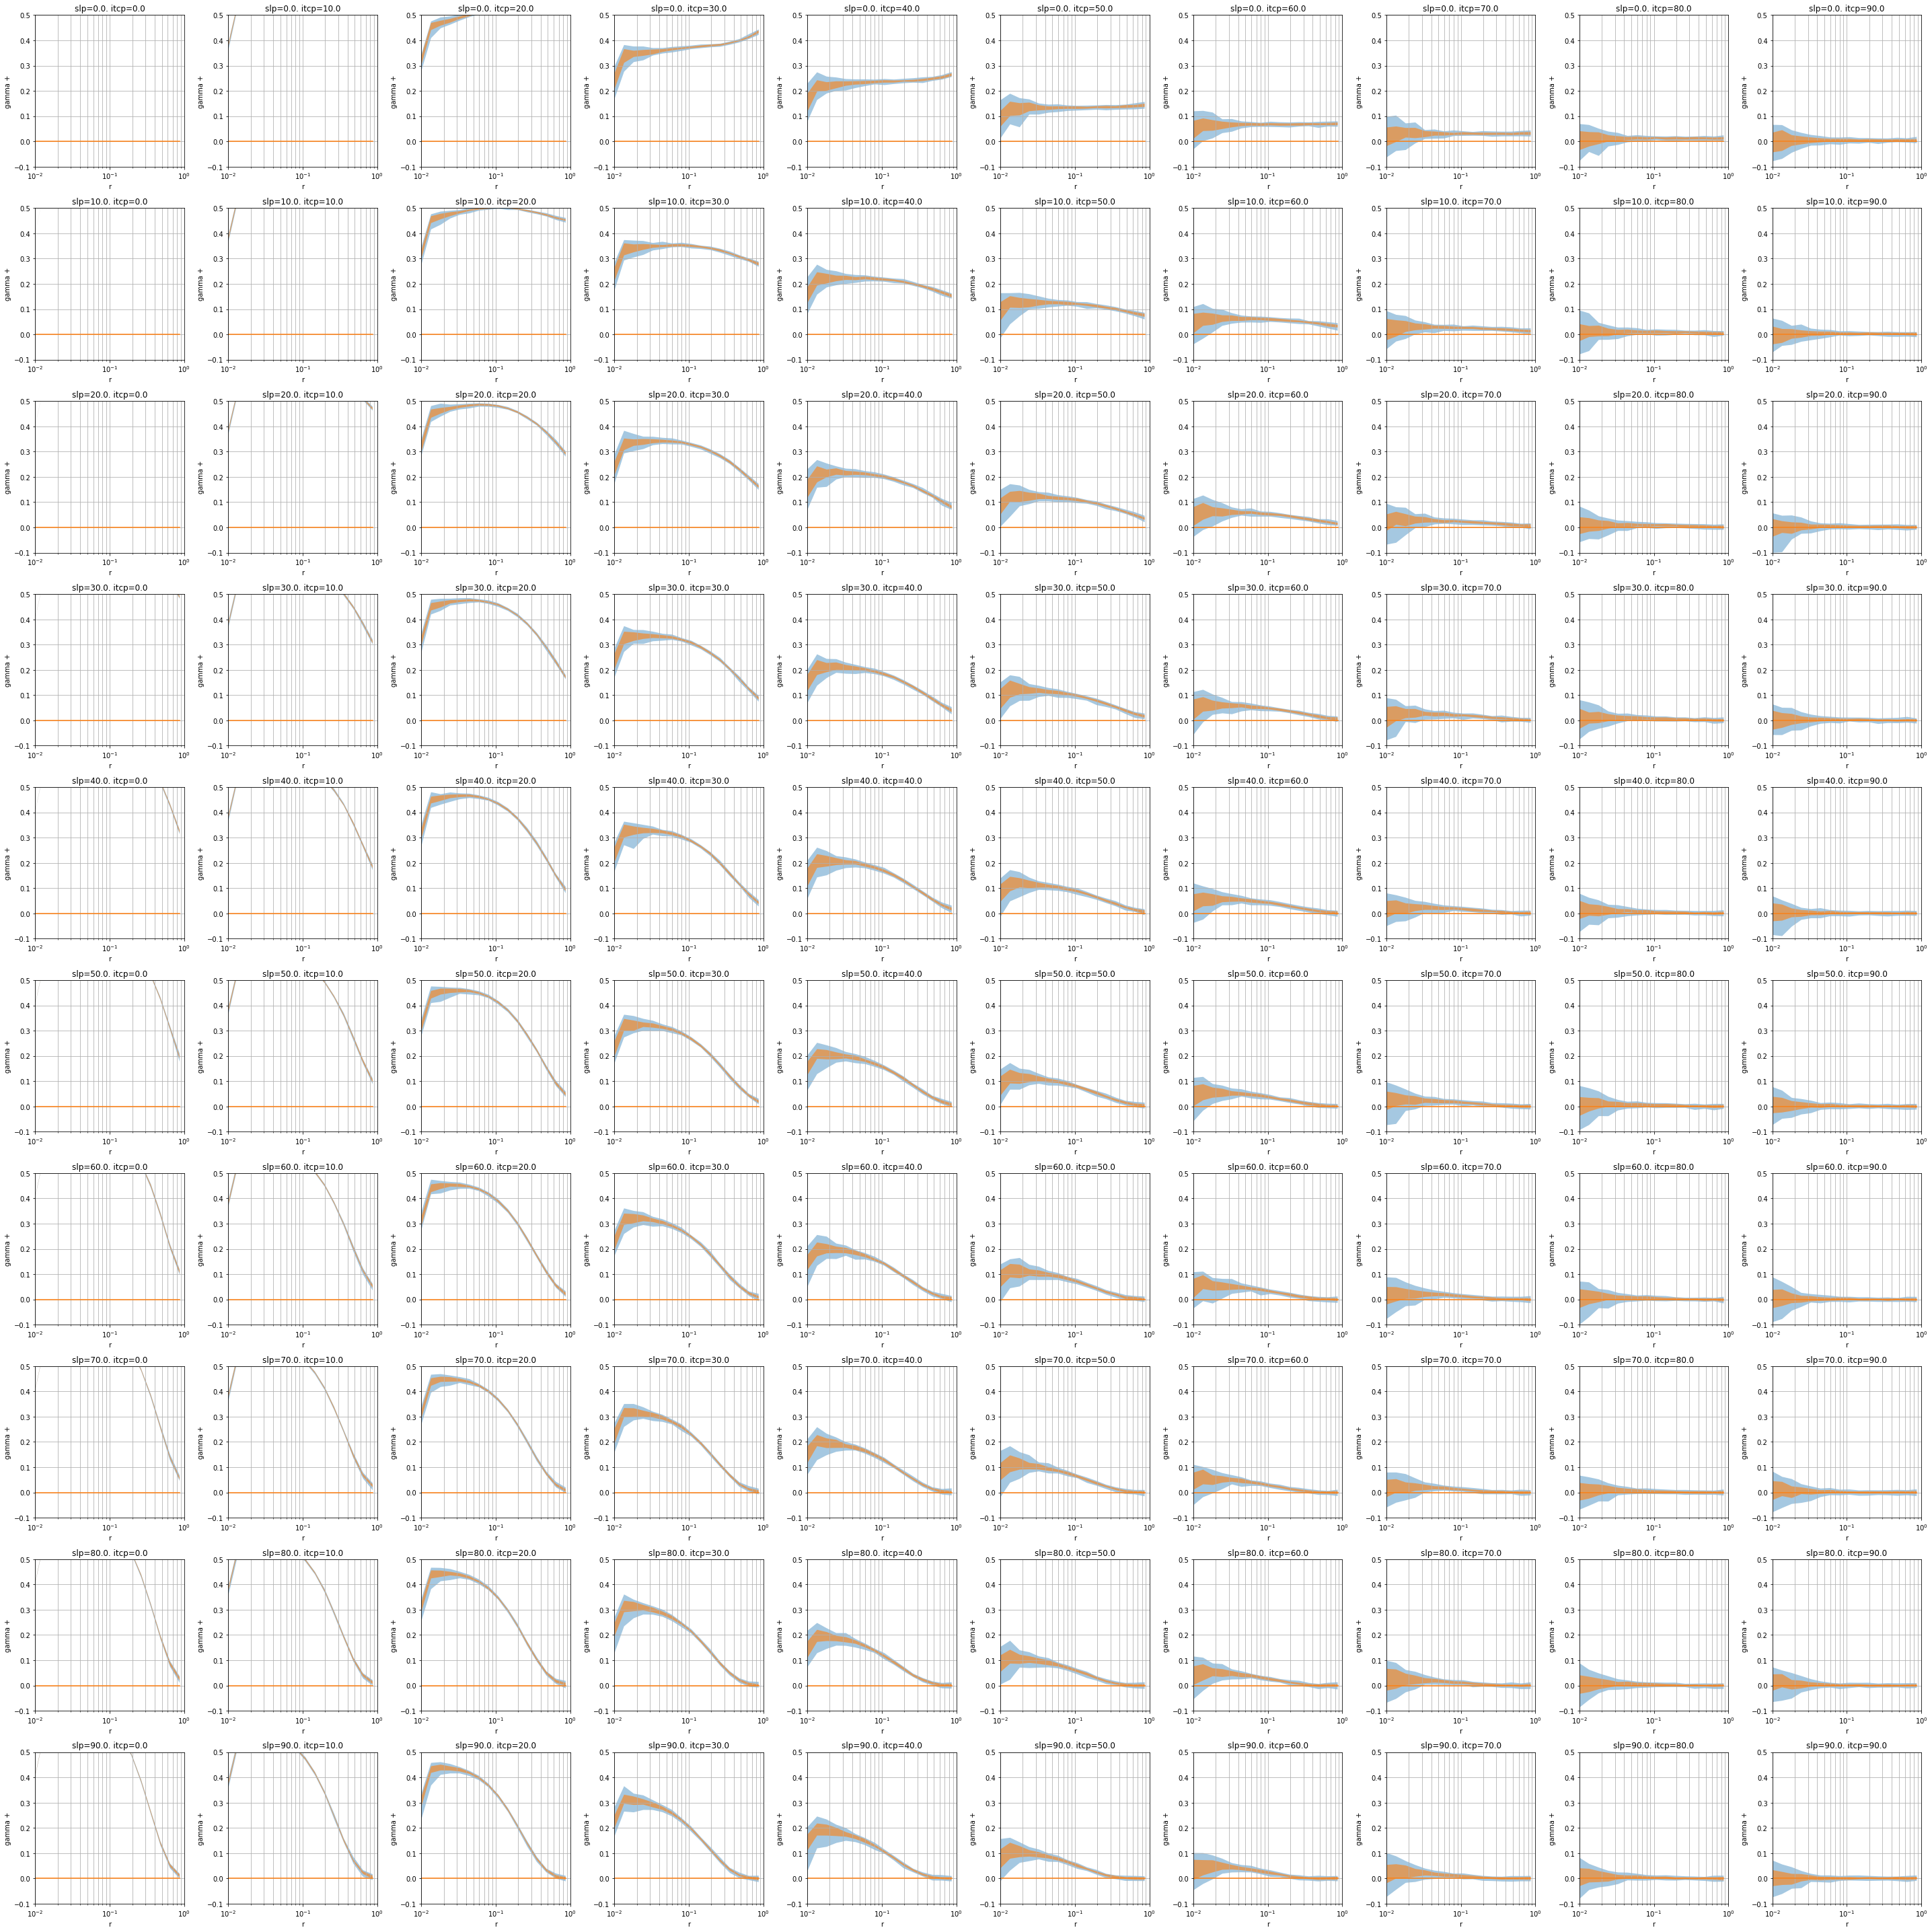

In [2]:
import sys
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#local modules, no name conflicts
from ia_geometry_func import *
from execution_func import *
from ia_plot import *
from ia_plot_cross_condition import *

n=32
baR_0 = 0.3
concentration = 20 #R_virial = Rs*c. since R_virial is usually chosen as the cut of limit for density profiles, we set it to 1.
a1s = np.linspace(0,np.pi/2,10)
a2s = np.linspace(0,np.pi/2,10)
#smr_slope_run = 0#np.pi/8 #radians/normalized_distance
#smr_intercept_run = np.pi/8 #radians
density_std = 0 #fractional difference as std

folder_list = np.array([])
for smr_slope_run in a1s:
    for smr_intercept_run in a2s:
        run_folder = 'n %i c %i rhostd %1.2f baR_0 %1.2f slp %1.2f itcp %1.2f'%(n,concentration,density_std,baR_0,rad_to_deg(smr_slope_run),rad_to_deg(smr_intercept_run))
        folder_list = np.append(folder_list,run_folder)
linear_cross_condition_error_bar_plot(2,"Linear Smearing",folder_list,10,10)

made path /home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/Linear Smearing/test n 32 c 20 rhostd 0.00 baR_0 0.20 slp 0.00 itcp 22.50/STD
5.0 0.09635150424112991
10.0 0.01870886740662315
20.0 0.0032863281603111717
30.0 0.0011478426694881466
40.0 0.0005375976425504933


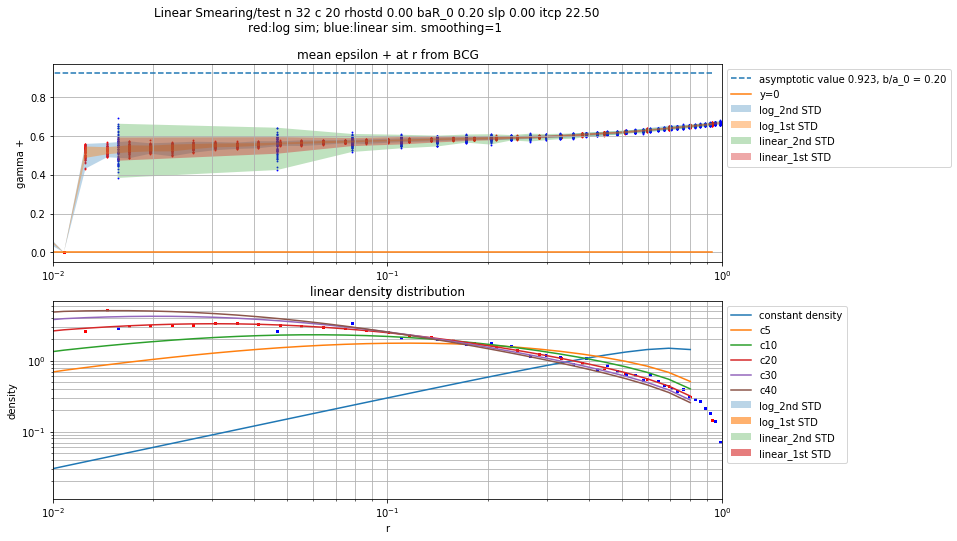

In [6]:
import sys
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#local modules, no name conflicts
from ia_geometry_func import *
from execution_func import *
from ia_plot import *

n=32
baR_0 = 0.2
concentration = 20 #R_virial = Rs*c. since R_virial is usually chosen as the cut of limit for density profiles, we set it to 1.

smr_slope_run = 0#np.pi/8 #radians/normalized_distance
smr_intercept_run = np.pi/8 #radians
density_std = 0 #fractional difference as std

run_folder = 'Linear Smearing/n %i c %i rhostd %1.2f baR_0 %1.2f slp %1.2f itcp %1.2f'%(n,concentration,density_std,baR_0,rad_to_deg(smr_slope_run),rad_to_deg(smr_intercept_run))
#run_folder = 'n %i rho const rhostd %1.2f baR_0 %1.2f smr %1.2f'%(n,density_std,baR_0,rad_to_deg(smr_run))

#run_folder = 'n %i c %i baR_0 %1.2f smr %1.2f'%(n,concentration,baR_0,rad_to_deg(smr_run))
#run_folder = 'n %i rho const baR_0 %1.2f smr %1.2f'%(n,baR_0,rad_to_deg(smr_run))

error_bar_plot(1,run_folder,True)